# **Univariate Time Series Transformer**
### (State of the Art)
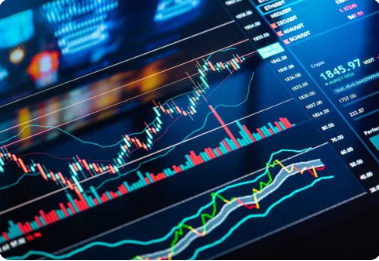

In [1]:
import optuna
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **Load and explore the data**

In [2]:
# Load Stock Market Data
dataset_path = "/kaggle/input/stock-market/NVDA_ticker.csv"
data = pd.read_csv(dataset_path, parse_dates=['Date'])

# Sort data by date to ensure proper sequence ordering
data = data.sort_values('Date').reset_index(drop=True)

# Use the 'Close' column as our target variable for univariate time series forecasting
close_prices = data['Close'].to_numpy().reshape(-1, 1)


In [3]:
# INFO

# Display the shape of the data
print("Data Shape:")
print(data.shape)

# Display the data types of the columns
print("\nData Types:")
print(data.dtypes.value_counts())

Data Shape:
(704, 5)

Data Types:
float64           3
datetime64[ns]    1
int64             1
Name: count, dtype: int64


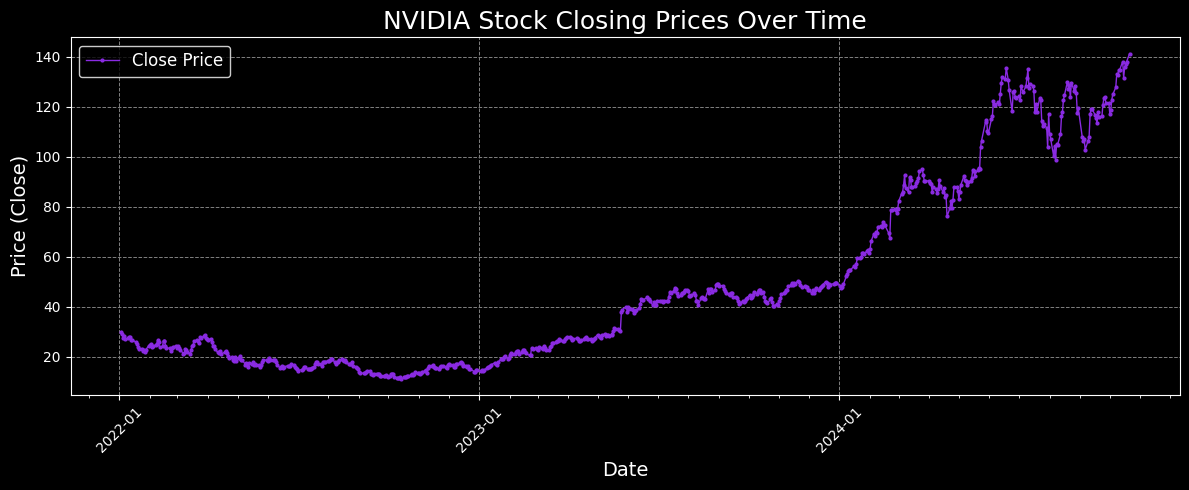

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Close Prices
plt.figure(figsize=(12, 5))

# Customize plot aesthetics
plt.style.use('dark_background')  # Black background for the plot
plt.plot(data['Date'], data['Close'], color='#8a2be2', linewidth=1, marker='o', markersize=2, label='Close Price')  # Purple line with markers

# Add labels and title with a white color font
plt.xlabel('Date', color='white', fontsize=14)
plt.ylabel('Price (Close)', color='white', fontsize=14)
plt.title('NVIDIA Stock Closing Prices Over Time', color='white', fontsize=18)

# Format date axis to make it readable
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for clarity
plt.xticks(rotation=45, color='white', fontsize=10)
plt.yticks(color='white', fontsize=10)

# Add a grid with custom colors and style
plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.7)


# Add a legend
plt.legend(facecolor='black', edgecolor='white', fontsize=12, loc='upper left')

plt.tight_layout()
plt.show()



## **Prepare data for machine learning**

In [5]:
# Data Preprocessing
scaler = StandardScaler()
close_prices = scaler.fit_transform(close_prices).flatten().tolist()

# Sequence Data Preparation
SEQUENCE_SIZE = 10  # Number of past days to consider in predicting the next day

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Create sequences
x_data, y_data = to_sequences(SEQUENCE_SIZE, close_prices)

# Split into training and test sets (80-20 split)
split_idx = int(len(x_data) * 0.8)
x_train, x_test = x_data[:split_idx], x_data[split_idx:]
y_train, y_test = y_data[:split_idx], y_data[split_idx:]

# Setup data loaders for batching
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# **Deep Learning**
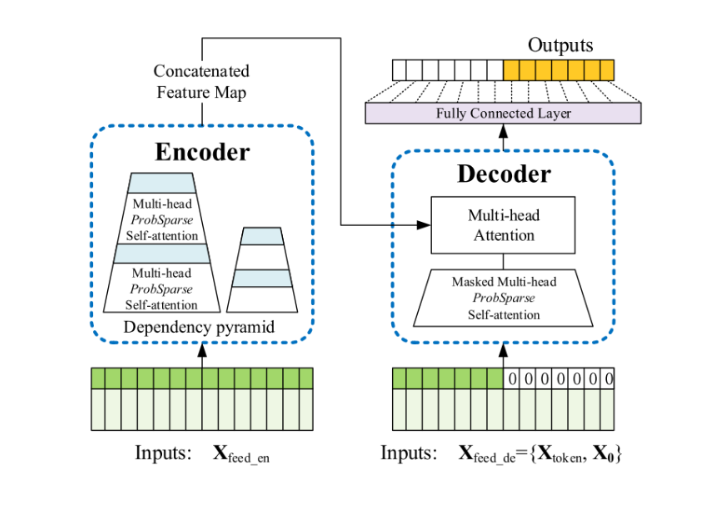
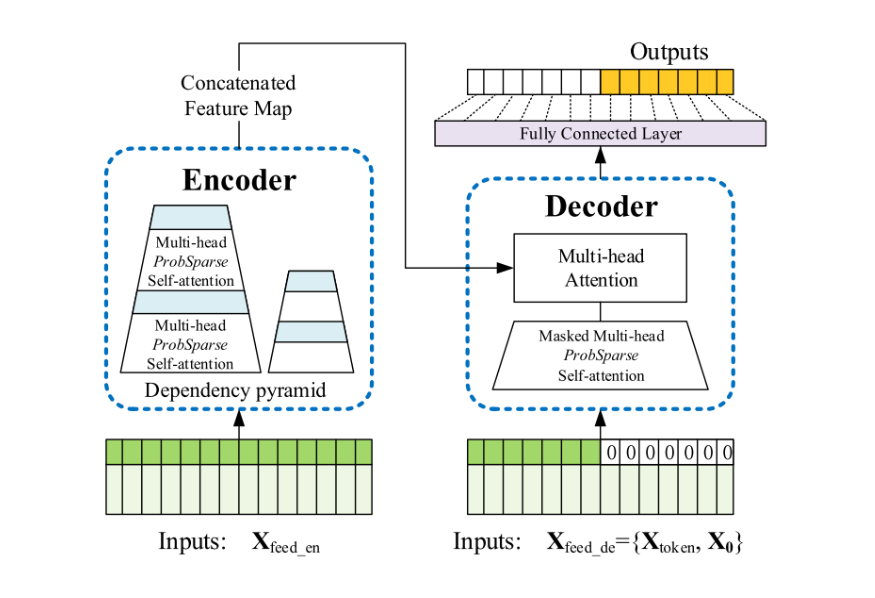

## **Build the Model**

In [6]:
# Positional Encoding with Learnable Parameters
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(LearnablePositionalEncoding, self).__init__()
        self.position_embedding = nn.Parameter(torch.zeros(max_len, d_model))
        nn.init.normal_(self.position_embedding, mean=0.0, std=0.1)
        
    def forward(self, x):
        return x + self.position_embedding[:x.size(0), :].unsqueeze(1)

# Transformer with ProbSparse Attention
class ProbSparseAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout):
        super(ProbSparseAttention, self).__init__()
        self.probsparse_attention = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        
    def forward(self, query, key, value, mask=None):
        return self.probsparse_attention(query, key, value, attn_mask=mask)[0]

In [15]:
# Updated Transformer Model for Time Series
class EnhancedTransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout, attention_type='full'):
        super(EnhancedTransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = LearnablePositionalEncoding(d_model)

        # Enable batch_first for better inference performance
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model * 4, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)

        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

# Optuna Objective Function with Updated API for Hyperparameters
def objective(trial):
    # Define hyperparameter search space
    d_model = trial.suggest_categorical("d_model", [64, 128, 256])
    nhead = trial.suggest_categorical("nhead", [2, 4, 8])
    num_layers = trial.suggest_int("num_layers", 2, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    attention_type = trial.suggest_categorical("attention_type", ["full", "probsparse"])
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)  # Replaced suggest_loguniform

    # Instantiate model with the suggested parameters
    model = EnhancedTransformerModel(
        input_dim=1, d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout, attention_type=attention_type
    ).to(device)

    # Training setup
    criterion = nn.SmoothL1Loss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)

    epochs = 50
    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # Validation step
        model.eval()
        val_losses = []
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_losses.append(loss.item())

        val_loss = np.mean(val_losses)
        scheduler.step(val_loss)

    return val_loss


## **Best Hyperparameters**

In [16]:
# Optuna Study with Extended Hyperparameters
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Retrieve best parameters and evaluate the best model on the test set
best_params = study.best_params
print("Best hyperparameters:", best_params)

Best hyperparameters: {'d_model': 256, 'nhead': 2, 'num_layers': 4, 'dropout': 0.40552559036504193, 'attention_type': 'probsparse', 'lr': 5.16206542971141e-05}


## **Train the Model**

In [26]:
# Ensure epochs is defined
epochs = 100  # or another appropriate value

# Final Model Training and Evaluation with Best Hyperparameters
best_model = EnhancedTransformerModel(
    input_dim=1,
    d_model=best_params["d_model"],
    nhead=best_params["nhead"],
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"],
    attention_type=best_params["attention_type"]
).to(device)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(best_model.parameters(), lr=best_params["lr"])
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=30)

early_stop_count = 0
min_val_loss = float('inf')

# Training Loop with Early Stopping and Scheduler Step
for epoch in range(epochs):
    best_model.train()
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = best_model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation step
    best_model.eval()
    val_losses = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = best_model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:  # Early stopping criterion
        print("Early stopping!")
        break
        
    # Print current epoch, validation loss, and learning rate
    current_lr = scheduler.get_last_lr()[0]  # Get the current learning rate
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}, Learning Rate: {current_lr:.6f}")



Epoch 1/100, Validation Loss: 0.1714, Learning Rate: 0.000052
Epoch 2/100, Validation Loss: 0.0400, Learning Rate: 0.000052
Epoch 3/100, Validation Loss: 0.0418, Learning Rate: 0.000052
Epoch 4/100, Validation Loss: 0.0352, Learning Rate: 0.000052
Epoch 5/100, Validation Loss: 0.0383, Learning Rate: 0.000052
Epoch 6/100, Validation Loss: 0.0387, Learning Rate: 0.000052
Epoch 7/100, Validation Loss: 0.0450, Learning Rate: 0.000052
Epoch 8/100, Validation Loss: 0.0393, Learning Rate: 0.000052
Early stopping!


## **Evaluate the best model**

In [27]:
# Model Evaluation
best_model.eval()
predictions = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = best_model(x_batch)
        predictions.extend(outputs.squeeze().tolist())

# Calculate RMSE
rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
print(f"Final Model Score (RMSE): {rmse:.4f}")


Final Model Score (RMSE): 8.8270


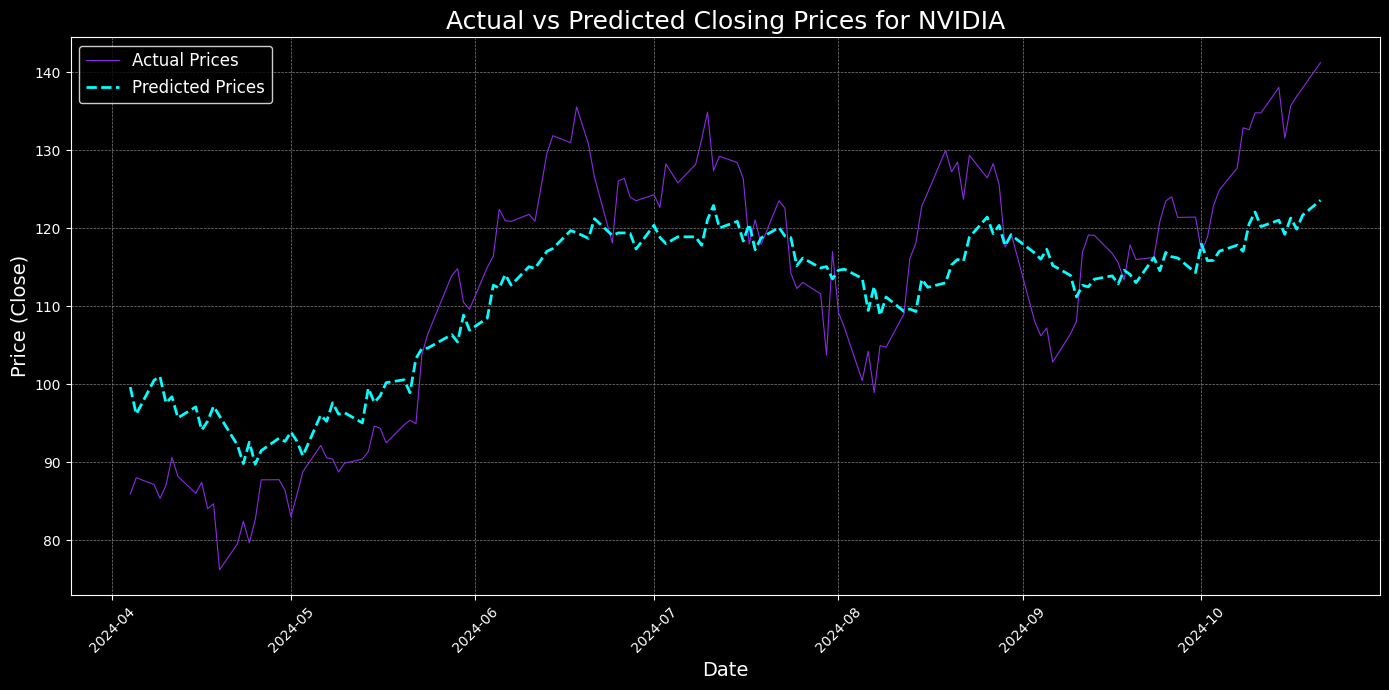

In [78]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Assuming y_test contains the actual values for the test set
# Convert predictions to a numpy array for plotting
predictions = np.array(predictions).reshape(-1, 1)

# Rescale the predictions and y_test back to original values if they were scaled
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Assuming you have the dates corresponding to your test data
test_dates = data['Date'].iloc[-len(y_test):]  # Get dates for the test set

# Create a plot
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(test_dates, y_test_rescaled, color='#8a2be2', label='Actual Prices', linewidth=0.8)


# Plot predicted values
plt.plot(test_dates, predictions_rescaled, color='aqua', label='Predicted Prices', linestyle='--', linewidth=2)

# Customize plot aesthetics
plt.style.use('dark_background')  # Black background for the plot
plt.title('Actual vs Predicted Closing Prices for NVIDIA', color='white', fontsize=18)
plt.xlabel('Date', color='white', fontsize=14)
plt.ylabel('Price (Close)', color='white', fontsize=14)
plt.xticks(rotation=45, color='white', fontsize=10)
plt.yticks(color='white', fontsize=10)

# Format date axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Add a grid with custom colors and style
plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5)

# Add legend
plt.legend(facecolor='black', edgecolor='white', fontsize=12)

plt.tight_layout()
plt.show()
